# Information Maximizing Generative Adversarial Networks

To understand intutuion behind this model follow this blog:

1. [Information Maximizing Generative Adversarial Network (InfoGAN): Introduction and Implementation](https://theailearner.com/2020/02/03/information-maximizing-generative-adversarial-network-infogan-introduction-and-implementation/)

### Introduction 

InfoGAN is an extension to the generative adversarial networks. Generative adversarial networks are trained to generate new images that look similar to the original images. But they do not provide any control over the generation of the new images. Let’s say you have trained a GAN network to generate new faces that look similar to the given dataset. But there you will not have any control over these faces such as the colour of the eyes, hairstyles, etc. But with the help of InfoGAN, we can achieve these results because InfoGAN is able to learn the disentangled representation.

### Imports and Initialize Parameters

In [1]:
from keras.layers import Input, Dense, Reshape, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D, AveragePooling2D, Flatten, Embedding, Concatenate
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np

Using TensorFlow backend.


In [2]:
import tensorflow as tf

#ignore warnings in the output
tf.logging.set_verbosity(tf.logging.ERROR)

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
batch_size = 16
half_batch_size = 8
latent_dim = 100 + 10
iterations = 60000
optimizer = Adam(0.0002, 0.5)

### Generator Network in InfoGAN

Input to the generator network consists of shape (110, 1), where 100 is the noise vector size and 10 is the latent code size. Here latent codes are one-hot encoded discrete number between 0-9. I have used deconvolutional layers to upsample and finally produce the shape of (28,28,1). Batch normalization is used to improve the quality of the trained network and for stabilization.

In [13]:
def generator():

    input_gen = Input(shape = (latent_dim,))
    dense1 = Reshape((7,7,16))(Dense(7*7*16)(input_gen))

    batch_norm_1 = BatchNormalization()(dense1)
    trans_1 = Conv2DTranspose(128, 3, padding='same', activation=LeakyReLU(alpha=0.2), strides=(2, 2))(batch_norm_1)
    batch_norm_2 = BatchNormalization()(trans_1)
    trans_2 = Conv2DTranspose(128, 3, padding='same', activation=LeakyReLU(alpha=0.2), strides=(2, 2))(batch_norm_2)
    output = Conv2D(1, (28,28), activation='tanh', padding='same')(trans_2)
    gen_model = Model(input_gen, output)
    gen_model.compile(loss='binary_crossentropy', optimizer=optimizer)
    print(gen_model.summary())

    return gen_model

In [15]:
generator_model = generator() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 110)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 784)               87024     
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 16)          0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 14, 14, 128)       18560     
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 28, 28, 128)       147584    
__________

### Discriminator and Auxiliary Network InfoGAN

Auxiliary network shares all the weights of the discriminator network except the output layer there is no need to create two separate functions for this. Networks take images of shape (28, 28, 1) as input. convolutional, batch normalization and pooling layers are used to create the network. The output shape of the discriminator network is 1 as it only predicts the input image is real or fake. But the output shape of the auxiliary network is 10 as it predicts latent code.

In [16]:
def discriminator():

    input_disc = Input(shape = (28, 28, 1))

    conv_1 = Conv2D(16, 3, padding = 'same', activation = LeakyReLU(alpha=0.2))(input_disc)
    batch_norm1 = BatchNormalization()(conv_1)
    pool_1 = AveragePooling2D(strides = (2,2))(batch_norm1)
    conv_2 = Conv2D(32, 3, padding = 'same', activation = LeakyReLU(alpha=0.2))(pool_1)
    batch_norm2 = BatchNormalization()(conv_2)
    pool_2 = AveragePooling2D(strides = (2,2))(batch_norm2)
    conv_3 = Conv2D(64, 3, padding = 'same', activation = LeakyReLU(alpha=0.2))(pool_2)
    batch_norm3 = BatchNormalization()(conv_3)
    pool_3 = AveragePooling2D(strides = (2,2))(conv_3)
    flatten_1 = Flatten()(pool_3)
    output = Dense(1, activation = 'sigmoid')(flatten_1)
    q_output_catgorical = Dense(10, activation = 'softmax')(flatten_1)
    
    disc_model = Model(input_disc, output)
    disc_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    q_model = Model(input_disc, q_output_catgorical)
    q_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    print(disc_model.summary())
    print(q_model.summary())

    return disc_model, q_model

In [17]:
discriminator_model, auxiliary_model = discriminator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
average_pooling2d_4 (Average (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
batch_normalization_11 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
average_pooling2d_5 (Average (None, 7, 7, 32)          0         
__________

### Combined Network in InfoGAN

A combined model is created to train the generator network. Here we do discriminator network as non-trainable as discriminator network is trained separately. The combined model takes random noise and latent code as input. This input is fed to the generator network and the generated image is fed to both discriminator and auxiliary network.

In [18]:
def combined():

    inputs = Input(shape = (latent_dim,)) 
    gen_img = generator_model(inputs)
    
    discriminator_model.trainable = False
    
    disc_outs = discriminator_model(gen_img)
    q_outs = auxiliary_model(gen_img)
    
    comb_model = Model(inputs, [disc_outs, q_outs])
    comb_model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=optimizer, metrics=['accuracy'])
    print(comb_model.summary())

    return comb_model

In [19]:
combined_model = combined()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 110)          0                                            
__________________________________________________________________________________________________
model_6 (Model)                 (None, 28, 28, 1)    354097      input_7[0][0]                    
__________________________________________________________________________________________________
model_7 (Model)                 (None, 1)            24065       model_6[1][0]                    
__________________________________________________________________________________________________
model_8 (Model)                 (None, 10)           29258       model_6[1][0]                    
Total params: 407,324
Trainable params: 382,971
Non-trainable params: 24,353
________________________________

### Training the InfoGAN Model

Training a GAN model is always a difficult task. A careful hyperparameter tuning is always required. We will use the following steps to train the InfoGAN model.

1. Normalize the input images from the MNIST dataset.
2. Train the discriminator model using real images from the MNIST dataset.
3. Train the discriminator model using real images and corresponding labels.
4. Train the discriminator model using fake images generated from the generator network.
5. Train the auxiliary network using fake images generated from the generator and random latent codes.
6. Train the generator network using a combined model without training the discriminator.
7. Repeat the steps from 2-6 for some iterations. I have trained it for 60000 iterations.

In [22]:
def train():

    train_data = (x_train.astype(np.float32) - 127.5) / 127.5
    train_data = np.expand_dims(train_data, -1)
    train_data_y = y_train

    for i in range(iterations):

        batch_indx = np.random.randint(0, train_data.shape[0], size = (half_batch_size))
        batch_x = train_data[batch_indx]
        batch_y = to_categorical(train_data_y[batch_indx], 10)

        real_loss = discriminator_model.train_on_batch(batch_x, np.ones((half_batch_size,1)))

        q_real_loss = auxiliary_model.train_on_batch(batch_x, batch_y)

        random_y = to_categorical(np.random.randint(0,10,half_batch_size), 10)
        input_noise = np.random.normal(0, 1, size=(half_batch_size, 100))
        
        gen_outs = generator_model.predict(np.hstack((input_noise, random_y)))

        fake_loss = discriminator_model.train_on_batch(gen_outs, np.zeros((half_batch_size,1)))
        q_fake_loss = auxiliary_model.train_on_batch(gen_outs, random_y)

        noise = np.random.normal(0, 1, size=(batch_size, 100))
        latent_code = to_categorical(np.random.randint(0,10,batch_size), 10)

        full_batch_input_noise = np.hstack((noise, latent_code))

        gan_loss = combined_model.train_on_batch(full_batch_input_noise, [np.ones((batch_size,1)), latent_code])
        
        if i%5000 == 0:
            print(i, fake_loss, real_loss, gan_loss, q_real_loss, q_fake_loss)

In [23]:
if __name__ == '__main__':
    train()

0 [1.0074317, 0.0] [0.14327386, 1.0] [2.9203196, 0.56781244, 2.352507, 1.0, 0.0625] [1.8851708, 0.25] [2.3756733, 0.0]
5000 [0.7622657, 0.125] [0.590624, 0.875] [0.63276285, 0.63077855, 0.0019843245, 0.875, 1.0] [0.3524941, 0.875] [0.02102179, 1.0]
10000 [0.7550068, 0.125] [0.6877359, 0.375] [0.7326824, 0.7326349, 4.748634e-05, 0.125, 1.0] [0.00078241853, 1.0] [8.426499e-05, 1.0]
15000 [0.74028, 0.0] [0.69417006, 0.5] [0.7144358, 0.7143568, 7.904324e-05, 0.25, 1.0] [1.1724569, 0.75] [5.5134353e-07, 1.0]
20000 [0.7385715, 0.25] [0.6516497, 0.75] [0.73071253, 0.73071223, 3.1292473e-07, 0.375, 1.0] [2.7546439e-05, 1.0] [3.9190463e-06, 1.0]
25000 [0.75472355, 0.125] [0.7017891, 0.5] [0.7123962, 0.7123961, 1.192093e-07, 0.4375, 1.0] [0.023473533, 1.0] [1.192093e-07, 1.0]
30000 [0.76911974, 0.25] [0.6105095, 0.875] [0.7278525, 0.7278524, 1.192093e-07, 0.375, 1.0] [0.010760284, 1.0] [1.192093e-07, 1.0]
35000 [0.7577925, 0.25] [0.71616757, 0.25] [0.7481926, 0.7481925, 1.192093e-07, 0.0625, 1.0

### Generating Results from Trained Model

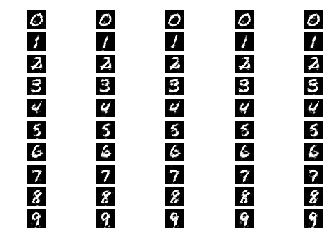

In [25]:
import matplotlib.pyplot as plt

r, c = 10, 5

gen_imgs = []

for indx in range(10):
    
    noise = np.random.normal(0, 1, (5, 100))
    categorical_code = to_categorical([indx]*5, 10)
    
    input_noise = np.hstack((noise, categorical_code))
    outs = generator_model.predict(input_noise)
    gen_imgs.extend(outs)
    
# Rescale images 0 - 1
gen_imgs = np.array(gen_imgs)
gen_imgs = 0.5 * gen_imgs + 0.5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
        
plt.show()
fig.savefig("mnist.png")
plt.close()